# Lab 5 : Detecting Parkinson's Disease using speech
In this lab, we will learn how to detect Parkinson's Disease using speech data. Some key-points to learn are:

*   How to load and explore new dataset
*   How to split train-val-test set (when you have per-patient data)
*   How to extract features from audio (MFCCs)
*   How to train different models for two-class classification problem
*   How to use validation data for selecting model parameters
*   How to implement functions to compute accuracy, sensitivity, specificity, f1, precision, recall 
*   How to implement ROC curve
*   How to compute ROC AUC (optional)

We will be using **Italian Parkinson's Voice and speech** dataset. Please read [the paper for more details on the dataset.](https://ieeexplore.ieee.org/document/8070308)

- Upload data to your Google Drive

 > - Create your IEEE account
https://www.ieee.org/profile/public/createwebaccount/showCreateAccount.html?url=https%3A%2F%2Fwww.ieee.org%2Fabout%2Fhelp%2Fmy-account.html&ShowMGAMarkeatbilityOptIn=true
 > - Login to your account and download dataset from Dataset Files by clicking on Italian Parkinson’s Voice and speech at  (https://ieee-dataport.org/open-access/italian-parkinsons-voice-and-speech#files )
 > - Uncompress the zipped folder
 > - Upload the extracted folder to your GoogleDrive

 > (This entire process should take you less than an hour, depending on your internet speed)

## Library Imports

In [1]:
import os
import pandas as pd
from IPython.display import display 
import IPython
import numpy as np

In [2]:
# YOUR IMPORTS HERE
import google
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
import librosa
from scipy.stats import kurtosis, skew
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')

## Task 1 [20 points]
Load and explore dataset


###### Mount your Google drive [2 point]

In [3]:
# YOUR CODE HERE
google.colab.drive.mount('/content/drive', force_remount=True)
drive = pathlib.Path('./drive/MyDrive') / "2023JHU"/"2023MLMA"/"Italian Parkinson's Voice and speech"

Mounted at /content/drive


##### Explore the dataset in your drive. You may want to use `!ls <DIR_NAME>` or functions from `os` library to list files in directory to explore and understand the directory structure. For example, the first level of directories in the dataset are:

In [4]:
!ls drive/MyDrive/"2023JHU"/"2023MLMA"/"Italian Parkinson's Voice and speech"

'15 Young Healthy Control'    "28 People with Parkinson's disease"
'22 Elderly Healthy Control'


##### There is a file called `FILE CODES.xlsx` in each of the directories which will explain the naming convention for files. Read this file (from any one of the directories) using pandas and display its contents in a readable way. [3 point]

In [5]:
# YOUR CODE HERE
file = pd.read_excel("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/15 Young Healthy Control/FILE CODES.xlsx")
file = file.iloc[3:,1:]
file["Unnamed: 2"]=pd.Series(file["Unnamed: 2"]).fillna(method='ffill')

In [6]:
display(file)

,Unnamed: 1,Unnamed: 2
3,B1,first reading of the phonemically balanced tex...
4,B2,second reading of the phonemically balanced te...
5,D1,execution of the syllable ‘pa’ (5 sec)
6,D2,execution of the syllable ‘ta’ (5 sec)
7,FB1,reading of some phonemically balanced phrases
8,FB2,reading of some phonemically balanced words
9,VA1,2 phonation of the vocal ‘a’
10,VA2,2 phonation of the vocal ‘a’
11,VE1,2 phonation of the vocal ‘e’
12,VE2,2 phonation of the vocal ‘e’


##### Prepare Dataframe (metadata_PD) for Initial Analysis of the Dataset [5 points]
Explore the dataset by reading the other `.xlsx` files in each folder containing the list of subjects in that folder and their age and gender among other things. Read these files into a pandas dataframe for initial analysis of dataset.

Go through this dataset in detail and ensure the following in your dataframe:

1. Make sure the correct data is being read from the excel files. (HINT: pandas allows you to read excel data with its funcions and has excellent parameters to help you input the exact data you want from the excel file)
2. Because of inconsistencies in the excel data sheet, you might see a bunch of NaNs. Feel free to use pandas functions like `dropna()` and `fillna()` to fix/remove NaN data values in dataframe.

In [7]:
# YOUR CODE HERE
metadata_HC = pd.read_excel("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/15 Young Healthy Control/15 YHC.xlsx",header=1)
metadata_HC = metadata_HC.dropna()
metadata_HC["drive"] = "drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/15 Young Healthy Control/"
metadata_HC["label"] = "Healthy"
metadata_HC2 = pd.read_excel("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/22 Elderly Healthy Control/Tab 3.xlsx",header=1)
metadata_HC2 = metadata_HC2.dropna()
metadata_HC2["drive"] ="drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/22 Elderly Healthy Control"
metadata_HC2["label"] = "Healthy"
metadata_PD = pd.read_excel("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/TAB 5.xlsx",header=1)
metadata_PD = metadata_PD.iloc[:,1:]
metadata_PD = metadata_PD.dropna()
metadata_PD["drive"] = "drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/"
metadata_PD["label"] = "Parkinson"
metadata_HC = metadata_HC.append(metadata_HC2, ignore_index=True)
metadata_HC = metadata_HC.drop(columns=['from'])
metadata_PD.columns = metadata_HC.columns
metadata_PD = metadata_HC.append(metadata_PD, ignore_index=True)

In [8]:
display(metadata_PD)

,name,surname,sex,age,time1,CPS1,time2,CPS2,time3,CPS3,drive,label
0,Davide,M,M,19.0,45.61,11.357159,54.2,9.557196,53.71,5.231800,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,Healthy
1,Giuseppe Andrea,M,M,21.0,50.7,10.216963,47.2,10.974576,59.72,4.705291,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,Healthy
2,Alessandro,M,M,20.0,40.02,12.943528,40.12,12.911266,46.71,6.015842,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,Healthy
3,Giuseppe,M,M,29.0,41.61,12.448931,42.42,12.211221,38.50,7.298701,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,Healthy
4,Nicolas,M,M,22.0,45.32,11.429832,46.52,11.134996,53.42,5.260202,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,Healthy
...,...,...,...,...,...,...,...,...,...,...,...,...
60,Mario,M,M,72.0,117.6,4.404762,98.8,5.242915,87.51,3.211062,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,Parkinson
61,Nicola,M,M,65.0,164.1,3.156612,//,//,151.30,1.857237,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,Parkinson
62,Nicolo',C,M,65.0,233,1.759657,//,//,217.30,0.957202,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,Parkinson
63,Vito,L,M,70.0,112,4.625,106.6,4.859287,68.31,4.113600,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,Parkinson


##### ❓ QUESTION❓ [5 points]
Is the dataset age and gender balanced? Support your answer with statistics from dataset


`YOUR ANSWER HERE`
The age and gender is not balanced.

there are  23  female
there are  42  male
the gender ratio (F:M) is about  0.5476190476190477


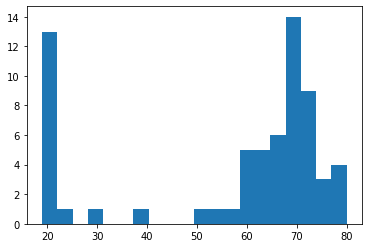

In [9]:
# YOUR CODE HERE
print("there are ",sum(metadata_PD["sex"]=='F')," female")
print("there are ",sum(metadata_PD["sex"]=='M')," male")
print("the gender ratio (F:M) is about ", sum(metadata_PD["sex"]=='F')/sum(metadata_PD["sex"]=='M'))
plt.hist(metadata_PD["age"],20)
plt.show()

##### ❓ QUESTION❓ [5 points]
 The aim of this lab is to detect Parkinson's disease traits on speech using audio analysis and machine learning. This is a bi-class problem, so a classifier will give us the probability that an observation comes from a person with PD. Which of these 3 directories will you use and why? Please support your answer with facts from the database. You may want to use the `.xlsx` files in each directory <br>

`YOUR ANSWER HERE`
We should only use samples from 22 Elderly Healthy Control and 28 People with Parkinson's disease. Because in this way, the age will be more balanced



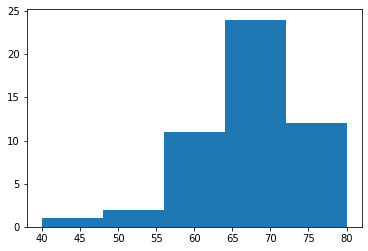

In [10]:
# YOUR CODE HERE
metadata_PD = metadata_PD[metadata_PD["drive"] != "drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/15 Young Healthy Control/"]
plt.hist(metadata_PD["age"],5)
plt.show()

## Task 2 [30 points]

As we said before, the goal of this lab is to train models to detect PD-related traits in speech and differentiate between people with and without PD automatically. But we will need to do some grid-search to find the optimal hyperparameters and also a cross-validation to report our best results. In the experiments, we will use the audios B1, B2 (2 recordings per speaker). We will divide our dataset into five partitions to do a 5-fold cross-validation. At each iteration, we will employ 3 partitions of the data for training, 1 for validation and 1 for testing.
Have in mind that the audio from a speaker cannot be in two different folds!

##### Traverse through subdirectories and make dataframe with header <br>
Make a dataframe named DATAPD with headers as {`speaker`, 	`gender` , `age`, `audio_file_for_spk_with_path`,`label_parkinsons`, `#fold`}  <br>
You will need to use the excel files in the dataset to get `age` and `gender`. Please note that we will use only audio files starting with `B1` and `B2` for this lab, therefore, each speaker will have two rows: one for each audio. #fold indicates in which partition the recording will be allocated. #fold can go from 1 to 5.

Medical datasets can have a plethora of inconsistencies in the real world and it becomes important to efficiently deal with these inconsistencies in dataset in the most efficient way possible. Here are a few tips for potential roadblocks you might face with this dataset:

1. The names in folders and those in the excel sheets might not always match. You can use python functions like `str.replace()` and `str.strip()` to drop special characters and unwanted white space in name strings. You can also use functions like `str.upper()` or `str.lower()` to deal with inconsistencies in capitalizations. Also the first names and last names in dataset can be merged (using `+` operator) before comparing with directory names. Please feel free to use various strategies of your own to deal with these issues. 
2. There may be duplicate recordings of the same person in the dataset. Please make sure to take only one and ignore the others. Also, state in a comment what you have done about the duplicate entries.
3. Some of the folders do not contain both `B1` and `B2` recordings. Have your code ignore those folders for this lab. 
4. A python package like `glob` can be used to search for path to `B1` and `B2` recordings in the folders but feel free to use your own strategy/function to do this.

[12 points]

In [11]:
# YOUR CODE HERE
#speaker, gender , age, audio_file_for_spk_with_path,label_parkinsons, #fold
DATAPD = pd.DataFrame()
metadata_PD = pd.read_excel("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/TAB 5.xlsx",header=1)
metadata_PD.index = range(1,30)
metadata_PD = metadata_PD.iloc[:,1:]
metadata_PD = metadata_PD.dropna()
x = np.array([1,2,3,4,5])
x = np.repeat(x, [5,6,6,5,6], axis=0)
random.Random(42).shuffle(x)
metadata_PD["#fold"] = x
for i in metadata_PD.index:
  age = metadata_PD.loc[i,"age"]
  gender = metadata_PD.loc[i,"sex"]
  name = metadata_PD.loc[i,"name"].strip().replace("*","").replace("o'","ò")
  sur = metadata_PD.loc[i,"surname"].strip().replace("*","")
  speaker = str(name+" "+sur)
  fold = metadata_PD.loc[i,"#fold"]
  if i <=5:
    if os.path.exists(str("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/1-5/"+speaker)) == True:
      drive = str("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/1-5/"+speaker)
    else: 
      print(i,speaker)
      continue
  elif i>5 and i<=10:
    if os.path.exists(str("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/6-10/"+speaker)) == True:
      drive = str("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/6-10/"+speaker)
    else:
      print(i,speaker)
      continue
  elif i>10 and i<=16:
    if os.path.exists(str("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/11-16/"+speaker)) == True:
      drive = str("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/11-16/"+speaker)
    else:
      print(i,speaker)
      continue
  elif i >16 and i <=28:
    if os.path.exists(str("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/17-28/"+speaker)) == True:
      drive = str("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/17-28/"+speaker)
    else:
      print(i,speaker)
      continue
  
  path = os.listdir(drive)
  path1 = np.nan
  path2 = np.nan
  for p in path:
    if p.startswith('B1'):
      path1 = os.path.join(drive,p)
    if p.startswith('B2'):
      path2 = os.path.join(drive,p)
  tmp = pd.DataFrame({"speaker": [speaker,speaker],"gender": [gender,gender], "age":[age,age],
                      "audio_file_for_spk_with_path":[path1,path2],"label_parkinsons":["PD","PD"],"#fold":[fold,fold]})
  DATAPD = DATAPD.append(tmp,ignore_index=True)



metadata_HC2 = pd.read_excel("drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/22 Elderly Healthy Control/Tab 3.xlsx",header=1)
metadata_HC2 = metadata_HC2.dropna()
x = np.array([1, 2,3,4,5])
x = np.repeat(x, [4,3,3,3,4], axis=0)
random.Random(43).shuffle(x)
n = 0
for i in metadata_HC2.index:
  name = metadata_HC2.loc[i,"name"].strip().upper().replace("*","")
  sur = metadata_HC2.loc[i,"surname"].strip().replace("*","")
  gender = metadata_HC2.loc[i,"sex"]
  age = metadata_HC2.loc[i,"age"]
  speaker = str(name+" "+sur)
  drive = "drive/MyDrive/2023JHU/2023MLMA/Italian Parkinson's Voice and speech/22 Elderly Healthy Control/"
  if os.path.exists(str(drive+speaker)) == True:
    path = os.listdir(str(drive+speaker))
    fold = x[n]
    n+=1
  else:
    continue
    print(str(drive+speaker))
  drive = str(drive+speaker)
  path1 = np.nan
  path2 = np.nan
  for p in path:
    if p.startswith('B1'):
      path1 = os.path.join(drive,p)
    if p.startswith('B2'):
      path2 = os.path.join(drive,p)
  tmp = pd.DataFrame({"speaker": [speaker,speaker],"gender": [gender,gender], "age":[age,age],
                      "audio_file_for_spk_with_path":[path1,path2],"label_parkinsons":["HC","HC"],"#fold":[fold,fold]})
  
  DATAPD = DATAPD.append(tmp,ignore_index=True)

24 Mario M


In [12]:
DATAPD = DATAPD.dropna()
DATAPD

,speaker,gender,age,audio_file_for_spk_with_path,label_parkinsons,#fold
0,Felicetta C,F,63.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,PD,4
1,Felicetta C,F,63.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,PD,4
2,Domenico C,M,50.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,PD,3
3,Domenico C,M,50.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,PD,3
4,Leonarda L,F,61.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,PD,2
...,...,...,...,...,...,...
83,GIOVANNA G,F,70.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,HC,4
84,NICOLA P,M,75.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,HC,3
85,NICOLA P,M,75.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,HC,3
86,GRAZIA G,F,72.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,HC,1


##### Train-val-test split [15 points]

Please explain in comments at the end your strategy to split Train-val-test split for the 5 folds (3 folds for training, 1 for validation and 1 for testing.)

NOTE: Train-validation-test sets CANNOT have any overlap! There should be no data leakage: the same speaker cannot have recordings in training and testing, even if those recordings are different.


I shuffled the patient list in each directory and randomlly split in 5 folds to make sure split base on patient level. I identified the validation and test set first to make sure they don't overlaps each term, and I set the training fold as the other folds except the test and validation folds. 

In [13]:
# YOUR CODE HERE
train_val_test = dict.fromkeys(["train","val","test"],[])
train_val_test["val"] = [2,3,4,5,1]
train_val_test["test"] = [1,2,3,4,5]
for i in range(5):
  f = [1,2,3,4,5]
  f.remove(train_val_test["val"][i])
  f.remove(train_val_test["test"][i])
  #print(f)
  train_val_test["train"].append(f)
train_val_test

{'train': [[3, 4, 5], [1, 4, 5], [1, 2, 5], [1, 2, 3], [2, 3, 4]],
 'val': [2, 3, 4, 5, 1],
 'test': [1, 2, 3, 4, 5]}

##### Check gender distribution for train, val and test for any one of the partitions [3 points]

In [14]:
# YOUR CODE HERE
test = DATAPD[DATAPD["#fold"]==train_val_test["test"][2]]
val = DATAPD[DATAPD["#fold"]==train_val_test["val"][2]]
train = DATAPD[DATAPD["#fold"].isin(train_val_test["train"][2])]

print("age mean for test: ", np.mean(test["age"]))
print("age mean for val: ", np.mean(val["age"]))
print("age mean for train: ", np.mean(train["age"]))

age mean for test:  66.11111111111111
age mean for val:  68.375
age mean for train:  67.08333333333333


## Task 3 [30 points]: Feature extraction
Generate a function that can calculate the Mel-Frequency Cepstral Coefficients (MFCC) features with 12 coefficients for a given audio. For this you will need frame the signals using hamming window, with 20 ms frame length and 10 msec overlap. Also concatenate delta features (first derivative) to obtain MFCC+deltas. After adding deltas you will have a 24-dimensional vector per each frame. If you add also the second derivative (optional) the vector will have 36 coefficients.

Use librosa python package to get mfcc features. librosa is a python package for audio analysis. Read the librosa documentation to learn about its implementation (https://librosa.org/doc/latest/index.html).

[12 points]

In [15]:
def get_mfcc_features(audio_file_path):
  '''
  Get mfcc features using librosa. The MFCC parameters should be 20 msec window, window overlap of 10 msec and 12 co-efficients of MFCC. 
  Also include delta co-efficients. 
  Returns concatenated mfcc delta of dimension (n_frame x n_dim)
  '''
  # YOUR CODE HERE
  # return mfcc_delta
  # Load the example clip
  
  y, sr = librosa.load(audio_file_path)
  n_fft = int(sr/1000*20)
  hop_length = int(sr/1000*10)
  mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=12,n_fft=n_fft)
  mfcc_delta = librosa.feature.delta(mfcc)
  mfcc_delta = np.vstack((mfcc,mfcc_delta))
  
  return mfcc_delta

##### MFCC features depend on number of frames of the files. Therefore, we will have a sequence and we should use a sequence-to-vector classifier in this case. However, to simplify the experiments, we will obtain a single vector from the sequence of MFCCs that we will use for classification. That vector will be called "MFCC statistics". In this task, you will have to obtain statistics for MFCC feature sequence (mean,variance,skewness,kurtosis) and use to obtain a final feature vector ("MFCC statistics") [8 points].



In [16]:
def get_mfcc_stats(mfcc_delta):
  '''
  Return stats of `mfcc_delta` features: mean, variance, kurtosis, skewness. These will be used as features for classifier
  '''
  # YOUR CODE HERE
  mfcc_stats = []
  for i in range(mfcc_delta.shape[0]):
    tmp = [np.mean(mfcc_delta[i]),np.var(mfcc_delta[i]),kurtosis(mfcc_delta[i]),skew(mfcc_delta[i])]
    #print(tmp)
    for j in tmp:
      mfcc_stats.append(j)
  # return mfcc_stats
  return np.array(mfcc_stats)

##### Using the previous functions, generate a function that can get MFCC statistics per speaker [10 points]
Since there are two files per speaker, you can obtain the MFCC features for each file using `get_mfcc_features`, concatenate the features and then obtain statistics using `get_mfcc_stats`. You can store these features in the dataframe by adding a new column.

Hint: For a recording, you have many frames, and each fram has a 24 dimensional vector. After obtaining statistics you will have a single vector that will have a dimension of 24x4 (mean, variance, kurtosis, skewness)

In [17]:
def add_features_to_df(DATAPD):
  """
  Input: DATAPD was generated in Task 2 and contains the paths to each audio.
  Output: DATAPDFEATS it's the same as DATAPD but it has a new column that contains one feature vector per audio file.
  The feature vectors are calculated with the MFCC-related functions created previously
  """
# YOUR CODE HERE
# You will have to use get_mfcc_features(audio_file_path) and get_mfcc_stats(mfcc_delta) here.
  DATAPD["feature"] = ""
  DATAPD["feature"] = DATAPD["feature"].astype(object)
  for i in DATAPD.index:
    mfcc_delta = get_mfcc_features(DATAPD.loc[i,"audio_file_for_spk_with_path"])
    mfcc_stats = get_mfcc_stats(mfcc_delta)
    DATAPD.at[i,"feature"] = mfcc_stats
  return DATAPD

In [18]:
# takes about 4 min
DATAPDFEATS = add_features_to_df(DATAPD)
DATAPDFEATS

,speaker,gender,age,audio_file_for_spk_with_path,label_parkinsons,#fold,feature
0,Felicetta C,F,63.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,PD,4,"[-574.3449096679688, 7339.04248046875, -1.0604..."
1,Felicetta C,F,63.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,PD,4,"[-573.2605590820312, 7789.4140625, -0.87454502..."
2,Domenico C,M,50.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,PD,3,"[-610.3612670898438, 18128.544921875, -1.22934..."
3,Domenico C,M,50.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,PD,3,"[-576.2311401367188, 14235.1005859375, -1.1444..."
4,Leonarda L,F,61.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,PD,2,"[-600.5389404296875, 11368.4873046875, -0.8640..."
...,...,...,...,...,...,...,...
83,GIOVANNA G,F,70.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,HC,4,"[-734.8178100585938, 9827.55078125, -0.9577708..."
84,NICOLA P,M,75.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,HC,3,"[-544.97314453125, 10126.3583984375, -1.091976..."
85,NICOLA P,M,75.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,HC,3,"[-572.1801147460938, 12615.5498046875, -1.0844..."
86,GRAZIA G,F,72.0,drive/MyDrive/2023JHU/2023MLMA/Italian Parkins...,HC,1,"[-707.4409790039062, 7454.21875, -0.8060340772..."


## Task 4 [20 points]
Train a **linear SVM** to do  bi-class classification {parkinsons, healthy control} using train and validation data for every fold. Optimize for SVM regularization parameter (C). Report your best system parameters and compute test accuracy. Use sklearn library for SVM. 

In [52]:
def accuracy(pred,t):
  acc = 0
  for i in range(len(pred)):
    if pred[i] == t[i]:
      acc +=1
  return acc/len(t)

In [53]:
# YOUR CODE HERE
# We recommend you to create this function:

def run_one_fold(DATAPDFEATS, TestFoldNumber, C):
  """
  INPUTS:
  - DATAPDFEATS contains the labels and features, as well as the #fold for each observation
  - TestFoldNumber indicates with #fold will be used as testing set in this iteration. 
  The remaining folds will be used for training but one that will be used as validation
  - C: SVM regularization parameter. To be used in grid-search

  OUTPUTS:
  - VPred: Vector containing the prediction scores for each validation observation
  - VTrue: Vector containing the true labels for each validation observation
  - TPred: Vector containing the prediction scores for each testing observation
  - TTrue: Vector containing the true labels for each testing observation

  """
  data = DATAPDFEATS[DATAPDFEATS["#fold"] != TestFoldNumber]
  n= TestFoldNumber-1
  val_data = data[data["#fold"] == train_val_test["val"][n]]
  train_data = data[data["#fold"].isin(train_val_test["train"][n])]

  train_y = train_data["label_parkinsons"].to_numpy().astype(int)
  train_x = []
  for i in train_data["feature"]:
    #print(i)
    train_x.append(i.tolist())

  val_y = val_data["label_parkinsons"].to_numpy().astype(int)
  val_x = []
  for i in val_data["feature"]:
    #print(i)
    val_x.append(i.tolist())
  
  
  train_x = np.array(train_x)
  val_x = np.array(val_x)
  #print(C)
  clf = svm.SVC(C=C,random_state=40,probability=True,kernel = 'poly')
  clf.fit(train_x, train_y)
  TPred = np.array(clf.predict_proba(train_x)[:,1]> 0.5).astype(int)
  VPred = np.array(clf.predict_proba(val_x)[:,1] > 0.5).astype(int)
  return VPred, val_y,TPred, train_y,clf



# You will also need extra code to perform grid-search (for loop...).
"""
 Example:
for C in [0.1, 1, 10, 100, 100]:
  for TestFOldNumber in range(1,5):
    VPred, VTrue, TPred, TTrue = run_one_fold(DATAPDFEATS, TestFoldNumber, C)
    
...
"""
DATAPDFEATS.label_parkinsons[DATAPDFEATS["label_parkinsons"]=="PD"] = 1
DATAPDFEATS.label_parkinsons[DATAPDFEATS["label_parkinsons"]=="HC"] = 0
#DATAPDFEATS
clf_list = dict()
acc_list = []
C_list = [0.1, 1,10,100,500,1000]
VPred_list = {0.1:[],1:[],10:[],100:[],500:[],1000:[]}
VTrue_list = {0.1:[],1:[],10:[],100:[],500:[],1000:[]}
TPred_list = {0.1:[],1:[],10:[],100:[],500:[],1000:[]}
TTrue_list = {0.1:[],1:[],10:[],100:[],500:[],1000:[]}
for C in C_list:
  acc = 0
  n = 0
  for TestFoldNumber in range(1,6):
    n +=1
    VPred, VTrue, TPred, TTrue, clf= run_one_fold(DATAPDFEATS, TestFoldNumber, C)
    clf_list[C] = clf
    acc += accuracy(VPred, VTrue)
    VPred_list[C].append(VPred)
    VTrue_list[C].append(VTrue)
    TPred_list[C].append(TPred)
    TTrue_list[C].append(TTrue)
  acc_list.append(acc/n)
    #print(TPred)
  print("C=",C,"; validation set accuracy=",acc/n)

C_best = C_list[np.argmax(acc_list)]
print("the best parameter c based on validation set model accuracy is ", C_best)


###############test
y_pred = []
clf = clf_list[C_best]
y_true = []
for TestFoldNumber in range(1,6):
  data = DATAPDFEATS[DATAPDFEATS["#fold"] == TestFoldNumber]
  x = []
  for s in data["feature"]:
    x.append(s.tolist())
  tmp_y = np.array(clf.predict_proba(x)[:,1] > 0.5)
  tmp_ytrue = data["label_parkinsons"].to_numpy().astype(int)
  for i in range(len(tmp_y)):
    y_pred.append(tmp_y[i])
    y_true.append(tmp_ytrue[i])
print("the test accuracy with the best parameter C is",accuracy(y_pred, y_true) )

C= 0.1 ; validation set accuracy= 0.5861862990810358
C= 1 ; validation set accuracy= 0.6350751879699248
C= 10 ; validation set accuracy= 0.8202756892230576
C= 100 ; validation set accuracy= 0.9092836257309942
C= 500 ; validation set accuracy= 0.885672514619883
C= 1000 ; validation set accuracy= 0.885672514619883
the best parameter c based on validation set model accuracy is  100
the test accuracy with the best parameter C is 0.9146341463414634


## Task 5 [15 points]

Write your own function to compute accuracy, sensitivity, specificity, f1, precison, recall using VPred and TPred obtained in the previous task. Report the testing results of the experiment and the hyperparameter C leading to those results.

In [54]:
# YOUR CODE HERE
def validation(pred,t):
  tp = 0.001
  tn = 0.001
  fp = 0.001
  fn = 0.001
  total = len(t)
  for i in range(len(pred)):
    if pred[i] == 1 and t[i] == 1:
      tp +=1
    elif pred[i] == 0 and t[i] == 0:
      tn +=1
    elif pred[i] == 1 and t[i] == 0:
      fp +=1
    elif pred[i] == 0 and t[i] == 1:
      fn +=1
  accuracy = (tp+tn)/total
  precison = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = 2*(precison*recall/(precison+recall))
  sensitivity = tp/(tp+fn)
  specificity = tn/(tn+fp)
  return accuracy, sensitivity, specificity, f1, precison, recall

In [55]:
acc_list = []
sen_list = []
spe_list = []
f1_list = []
pre_list = []
rec_list = []
for C in C_list:
  acc = 0
  sen = 0
  spe = 0
  f1_score = 0
  pre = 0
  rec = 0
  n = 0
  for i in range(5):
    n+=1
    accuracy, sensitivity, specificity, f1, precison, recall = validation(VPred_list[C][i], VTrue_list[C][i])
    acc += accuracy
    sen += sensitivity
    spe += specificity
    f1_score += f1
    pre += precison
    rec += recall
  acc_list.append(acc/n)
  sen_list.append(sen/n)
  spe_list.append(spe/n)
  f1_list.append(f1_score/n)
  pre_list.append(pre/n)
  rec_list.append(rec/n)
  print("C =",C)
  print("\t accuracy =",acc/n)
  print("\t sensitivity =",sen/n)
  print("\t specificity =",spe/n)
  print("\t f1 =",f1_score/n)
  print("\t precision =",pre/n)
  print("\t recall =",rec/n)

C = 0.1
	 accuracy = 0.5863098120300752
	 sensitivity = 0.8756776068685076
	 specificity = 0.12512704046580825
	 f1 = 0.7121228437286844
	 precision = 0.6176006858025358
	 recall = 0.8756776068685076
C = 1
	 accuracy = 0.635198700918964
	 sensitivity = 0.8645708154765227
	 specificity = 0.25841594416457536
	 f1 = 0.7348153680766287
	 precision = 0.6614793193836427
	 recall = 0.8645708154765227
C = 10
	 accuracy = 0.8203992021720969
	 sensitivity = 0.9013316379175201
	 specificity = 0.6832764068229861
	 f1 = 0.8580002437292276
	 precision = 0.8213532990244786
	 recall = 0.9013316379175201
C = 100
	 accuracy = 0.9094071386800333
	 sensitivity = 0.9599059489605608
	 specificity = 0.8332222592469177
	 f1 = 0.9295648425310745
	 precision = 0.9089761007708669
	 recall = 0.9599059489605608
C = 500
	 accuracy = 0.8857960275689223
	 sensitivity = 0.9432420596087863
	 specificity = 0.7999000333222259
	 f1 = 0.9124803581033252
	 precision = 0.8899206833957471
	 recall = 0.9432420596087863
C = 100

In [56]:
C_best = C_list[np.argmax(f1_list)]
print("the best C based on f1 score is", C_best)
y_pred = []
clf = clf_list[C_best]
y_true = []
y_prob = []
for TestFoldNumber in range(1,6):
  data = DATAPDFEATS[DATAPDFEATS["#fold"] == TestFoldNumber]
  x = []
  for s in data["feature"]:
    x.append(s.tolist())
  tmp_proba = clf.predict_proba(x)[:,1]
  tmp_y = np.array( tmp_proba > 0.5)
  tmp_ytrue = data["label_parkinsons"].to_numpy().astype(int)
  for i in range(len(tmp_y)):
    y_pred.append(tmp_y[i])
    y_true.append(tmp_ytrue[i])
    y_prob.append(tmp_proba[i])
accuracy, sensitivity, specificity, f1, precison, recall = validation(y_pred, y_true)
print("the test result is: ", y_prob)
print("the test accuracy = ",accuracy)
print("the test sensitivity = ",sensitivity)
print("the test specificity = ",specificity)
print("the test f1 = ",f1)
print("the test precison = ",precison)
print("the test recall = ",recall)

the best C based on f1 score is 100
the test result is:  [0.8869844687504793, 0.7561001030299013, 0.7881783089900584, 0.6945710380739055, 0.6973252801495856, 0.9068517517630384, 0.7986614464759163, 0.7772324067359001, 0.09542488766201153, 0.0990098627519584, 0.2044442513475994, 0.18215081738140326, 0.17757667476820035, 0.09801441085294578, 0.8150670237599884, 0.7545462639525404, 0.9920596161470773, 0.9663356770195006, 0.9009831349782168, 0.9999876445963248, 0.8836672953657599, 0.8455044043901602, 0.8076547426609562, 0.054069214599322506, 0.15146377123308716, 0.1234888646228943, 0.15399762560218258, 0.14335006504361708, 0.15132530796420013, 0.9999999995304143, 0.9786158195451959, 0.8295118353185288, 0.8146287617380638, 0.8682707127067653, 0.8433259777939969, 0.8682718624673909, 0.8749267825359242, 0.9999932072186041, 0.9999997079765269, 0.9357308076521794, 0.9402850010944228, 0.05820295495022694, 0.09525957749163289, 0.4533400363980242, 0.40481730271966526, 0.1515521123582132, 0.0442439

## Task 6 [15 points]
Write your own 
function to plot the ROC curve of the experiment providing the best test results. If you compared different experiments, you can plot different ROC curves. Do not use a library that already plots ROC curves, you have to build your own.


In [57]:
# YOUR CODE HERE
result = pd.DataFrame()
result["y_true"] = y_true
result["y_pred"] = y_prob
result = result.sort_values('y_pred', ascending=False)


In [58]:
from math import inf
def plot_roc(y_pred, y_true):
  P = len(y_true[y_true ==1])
  N = len(y_true[y_true ==0])
  FP = 0
  TP = 0
  f = -inf
  x = []
  y = []
  for i in range(len(y_pred)):
    if f != y_pred[i]:
      x.append(FP/N)
      y.append(TP/P)
      f = y_pred[i]
    if y_pred[i] > 0.5 and y_true[i] == 1:
      TP +=1
    elif y_pred[i] > 0.5 and y_true[i] == 0:
      FP +=1
  plt.plot(x,y)
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.show()

  return x, y




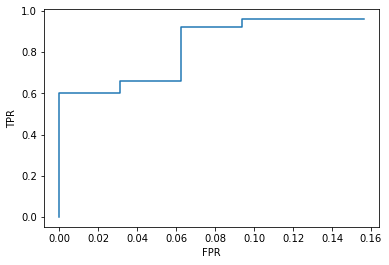

In [59]:
x,y = plot_roc(np.array(result["y_pred"]),np.array(result["y_true"]))

## Extra bonus task [20 points]
Write your own function to compute AUC ROC

In [60]:
# YOUR CODE HERE
def AUC_ROC(y_pred, y_true):
  P = len(y_true[y_true ==1])
  N = len(y_true[y_true ==0])
  TPR = []
  FPR = []
  thres = np.arange(0.0, 1.01, 0.1)
  for i in thres:
    #print(i)
    i = round(i,2)
    FP = 0
    TP = 0
    for y in range(len(y_pred)):
      if y_pred[y] >= i:
        if y_true[y] == 1:
          TP+=1
        elif y_true[y] == 0:
          FP +=1
    #print("FP",FP)
    TPR.append(TP/P)
    FPR.append(FP/N)
  #print(TPR,FPR)
  auc = -1 * np.trapz(TPR, FPR)
  return auc

In [61]:
print("AUC:", AUC_ROC(np.array(result["y_pred"]),np.array(result["y_true"])))

AUC: 0.9475


***

## Execute to finish lab [1 point]

In [29]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/19THRdXxmaI" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

**Congratulations!! You have finished Lab 5!!**